## Paris Agreement Scenario: 66% chance of staying below 2ºC

In [255]:
using PyPlot
using Random
using Distributions
using JuMP, Ipopt

In [256]:
include("../src/model.jl");
include("../src/ensemble.jl");
include("../src/diagnostics.jl");
include("../src/optimization.jl");
include("../src/plotting.jl");

In [267]:
# Model domain
dt = 1.
t = Array(2020:dt:2200);

GWP = 100. # global world product (trillion $ / year)

β = 0.02*GWP/(3.0)^2 # damages (trillion USD / year / celsius^2)
utility_discount_rate = 0.025 # ρ (relative low value from Stern review)

# Control technology cost scales (for full deployment, α=1.)
reduce_cost = 0.01*GWP;
remove_cost = 0.02*GWP;
geoeng_cost = 0.05*GWP;
adapt_cost = 0.03*GWP;

economics = Economics(
    β, utility_discount_rate,
    reduce_cost, remove_cost, geoeng_cost, adapt_cost,
    0., 0., 0., 0.,
    baseline_emissions(t)
);

In [268]:
Random.seed!(1)
d = Normal(0.65, 0.13)
Nsamples = 5000
feedback_samples = rand(d, Nsamples)

feedback_samples = feedback_samples[(feedback_samples .> 0.) .& (feedback_samples .<= 0.999)]
print("Filtered out ",Nsamples-length(feedback_samples), " unphysical samples.")

ECS₀ = 1.2
ECS_samples = ECS₀ ./ (1. .-feedback_samples);

Filtered out 23 unphysical samples.

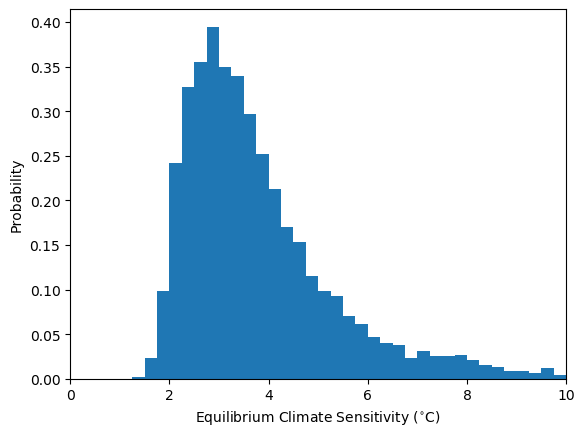

In [275]:
hist(ECS_samples, bins=0.:0.25:10., density=true)
xlim([0,10])
xlabel(L"Equilibrium Climate Sensitivity ($^{\circ}$C)")
ylabel("Probability");

In [270]:
ECS_threshold = quantile(ECS_samples, 2. /3.)

present_year = 2020.
name = "66.6% below";
controls = init_linear_controls(t);

model_threshold = ClimateModel(name, ECS_threshold, t, dt, controls, economics, present_year);
optimize_controls!(model_threshold, obj_option="temp", temp_goal = 2.);

Found optimal solution for model name: 66.6% below

In [271]:
ensemble = Dict{String, ClimateModel}();
first = true

for member_id in 1:length(ECS_samples)
    present_year = 2020.
    ECS = ECS_samples[member_id]
    name = "member $member_id";
    controls = model_threshold.controls;
    model = ClimateModel(name, ECS, t, dt, controls, economics, present_year);
    ensemble[name] = model
end

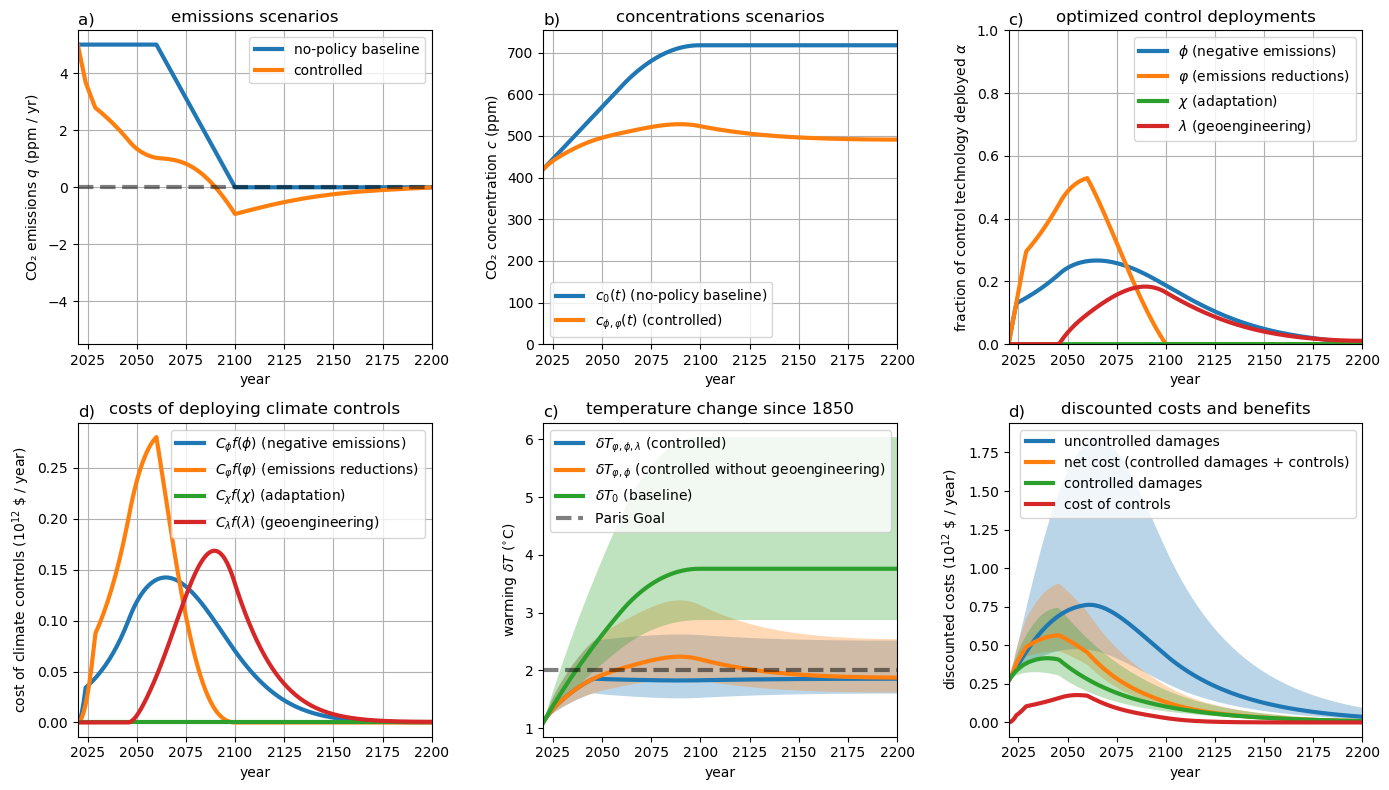

In [272]:
plot_ensemble(ensemble)
savefig("../figures/model_state_example_Paris-Agreement.png", bbox_inches="tight", dpi=100)

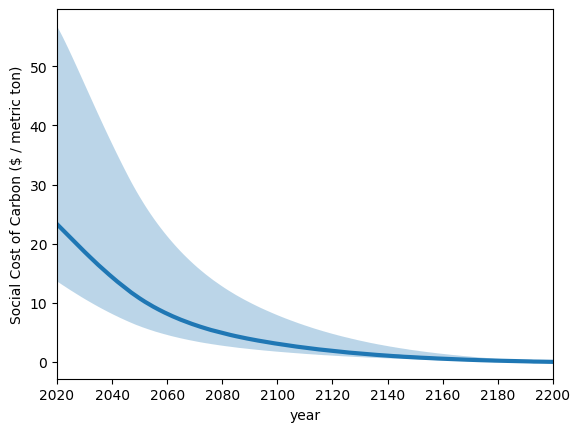

PyObject Text(24.00000000000002, 0.5, 'Social Cost of Carbon ($ / metric ton)')

In [273]:
SCCs = zeros(size(t)..., 3)
for (idx, year) in enumerate(t)
    first, median, ninth = ensemble_diagnostic_statistics_scalar(ensemble, SCC, t, year)
    SCCs[idx,1] = first;
    SCCs[idx,2] = median;
    SCCs[idx,3] = ninth;
end

fill_between(t, SCCs[:,1], SCCs[:,3], facecolor="C0", alpha=0.3)
plot(t, SCCs[:,2], "C0-", label="total (controlled) cost")
xlim(t[1], t[end])
xlabel("year")
ylabel("Social Cost of Carbon (\$ / metric ton)")